# Simulation to generate data set for DRM paper backtest (create arbitrary functional form)

In [2]:
import sys
sys.path.append('/Users/shuyangduuber.com/Desktop/sapphire_optimization/')
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.utils import resample
from xgboost import XGBRegressor
import scipy.stats as st
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Lasso

from sapphire_optimization.models.models_targeting.core.cost_curve import CostCurve
from sapphire_optimization.models.models_targeting.models.drm.drm_gradient import DRM_Gradient
from sapphire_optimization.models.models_targeting.core.data_transform_flow_targeting import DataTransformFlowTargeting
from sapphire_optimization.models.models_targeting.core.model_flow import ModelFlow

from sapphire_optimization.models.models_cte.models.r_learner import RLearnerRidge, RLearnerXGBT
from sapphire_optimization.models.models_cte.core.data_transform_flow_cte import DataTransformFlowCTE
from sapphire_optimization.models.models_cte.core.model_flow_cte import ModelFlowCTE

from sapphire_optimization.models.core.data_transform_flow import DataTransformFlow
from sapphire_optimization.models.core.model_flow_base import ModelFlowBase

from research.models.core.backtest import BackTest
from research.models.core.backtest_space import BackTestSpace
from sapphire_optimization.models.models_targeting.data.schema.rxgy_adrm import schema

from research.models.utils.plot import scatter_x_vs_y

from IPython.display import display
from copy import deepcopy

%matplotlib inline
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
sns.set()

/Users/shuyangduuber.com/Desktop/sapphire_optimization/env/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


# Load data

In [3]:
df_all = pd.read_csv(
    '/Users/shuyangduuber.com/Desktop/data/advanced_promo/rxgy_adrm_train_multimetric_US_20190602_20190804.csv'
)

/Users/shuyangduuber.com/Desktop/sapphire_optimization/env/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2714: DtypeWarning: Columns (8,9,10,11,13,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
df_all.columns

Index([u'rider_uuid', u'promo_city_id', u'cohort', u'proposal_start_datestr',
       u'rating_2driver_min_avg_84d', u'trip_incomplete_total_84d',
       u'days_active_84d', u'days_since_trip_first_lifetime',
       u'days_since_last_hard_churn_lifetime',
       u'days_since_last_soft_churn_lifetime', u'fare_max_sd_84d',
       u'churns_hard_lifetime', u'trips_lifetime', u'fare_max_p50_84d',
       u'duration_session_pre_request_max_p50_84d', u'trip_pool_per_x_84d',
       u'fare_total_win7d_sd_84d', u'trip_complete_win7d_sd_84d',
       u'session_per_days_active_84d', u'churns_soft_lifetime',
       u'trip_complete_per_days_active_84d', u'trip_pool_prc_84d',
       u'session_background_pre_request_prc_84d', u'session_lt_1m_prc_84d',
       u'session_request_prc_84d', u'duration_session_outside_total_prc_84d',
       u'trip_x_prc_84d', u'days_since_trip_last_lifetime',
       u'channel_signup_lifetime', u'device_os_primary_lifetime',
       u'promo_used_84d', u'has_session_request_84d',

In [5]:
df_all['label_vc_usd_28d'] = -df_all['label_vc_usd_28d']

In [6]:
value_col = 'label_trip_28d'
cost_col = 'label_vc_usd_28d'

# Preprocess features

In [7]:
dtf = DataTransformFlow(
    label_cols=[value_col],
    numerical_cols=schema.RIDER_CONTINUOUS_COLS,
    categorical_cols=[],
    log_cols=[],
    use_scale=True,
    use_pca=False,
    use_dummy=False,
)

In [8]:
X_base = dtf.fit_transform(dtf.pre_process(df_all))

In [9]:
schema.RIDER_CONTINUOUS_COLS

['rating_2driver_min_avg_84d',
 'trip_incomplete_total_84d',
 'days_active_84d',
 'days_since_trip_first_lifetime',
 'days_since_last_hard_churn_lifetime',
 'days_since_last_soft_churn_lifetime',
 'fare_max_sd_84d',
 'churns_hard_lifetime',
 'trips_lifetime',
 'fare_max_p50_84d',
 'duration_session_pre_request_max_p50_84d',
 'trip_pool_per_x_84d',
 'fare_total_win7d_sd_84d',
 'trip_complete_win7d_sd_84d',
 'session_per_days_active_84d',
 'churns_soft_lifetime',
 'trip_complete_per_days_active_84d',
 'trip_pool_prc_84d',
 'session_background_pre_request_prc_84d',
 'session_lt_1m_prc_84d',
 'session_request_prc_84d',
 'duration_session_outside_total_prc_84d',
 'trip_x_prc_84d',
 'days_since_trip_last_lifetime',
 'has_session_request_84d',
 'has_session_without_request_84d',
 'promo_used_84d']

In [10]:
X_base.shape

(1972139, 27)

# Create interaction and quadratic terms

In [12]:
X_interact = np.zeros([len(X_base), (1+10)*10/2])
cnt = 0
for i in range(10):
    for j in range(i, 10):
        X_interact[:, cnt] = X_base[:, i] * X_base[:, j]
        cnt +=1

In [13]:
X_interact.shape

(1972139, 55)

In [14]:
X_all = np.concatenate([X_base, X_interact], axis=1)

# Split features into 3 group for $b$ and $\tau$ generation

In [15]:
X_a = X_all[:, [i for i in range(X_all.shape[-1]) if i%3 == 0]]
X_b = X_all[:, [i for i in range(X_all.shape[-1]) if i%3 == 1]]
X_c = X_all[:, [i for i in range(X_all.shape[-1]) if i%3 == 2]]

In [16]:
print X_a.shape, X_b.shape, X_c.shape

(1972139, 28) (1972139, 27) (1972139, 27)


# Generate $b$, $\tau$ and $y$ 

$b^v = X_a \beta_1 + X_b \beta_2$  
$b^c = b^v + X_a \beta_3$  
$\tau^v = 2 + X_b \beta_4 + X_c \beta_5$  
$\tau^c = 4 + X_b \beta_6 + X_c \beta_7$  
$y^v = b^v + w\tau^v + \epsilon^v$  
$y^c = b^c + w\tau^c + \epsilon^c$  
where $\epsilon\sim N(0,1)$  
Superscript v means value and c means cost

In [17]:
np.random.seed(0)
w_all = np.random.randint(0, 2, len(X_all))

In [69]:
np.random.seed(0)
beta_lst = []
for X in [X_a, X_b, X_a, X_b, X_c, X_b, X_c]:
    beta_lst.append(np.random.uniform(-1, 1, X.shape[-1]))

b_v_all = X_a.dot(beta_lst[0]) + X_b.dot(beta_lst[1])
b_c_all = b_v_all + X_a.dot(beta_lst[2])
tau_v_all = 2 + X_b.dot(beta_lst[3]) + X_c.dot(beta_lst[4])
tau_c_all = 4 + X_b.dot(beta_lst[5]) + X_c.dot(beta_lst[6])
y_v_all = b_v_all + w_all*tau_v_all + np.random.normal(size=len(X_all))
y_c_all = b_c_all + w_all*tau_c_all + np.random.normal(size=len(X_all))

In [72]:
y_all = np.stack([y_v_all, y_c_all, w_all], axis=1)

In [73]:
CostCurve.sample_stats(y_all)

,count,Treatment Prct,Inc Cost Sum,Inc Cost P-val,Inc Value Sum,Inc Value P-val,CPIV
0,1972139.0,0.49938,5.336571e+06,0.0,4.058166e+06,0.0,1.31502


# Backtest

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.33, random_state=0)

In [75]:
model_drm = DRM_Gradient(
    dim_hidden_lst=[], 
    learning_rate=1e-1, 
    reg_scale=1e-1, 
    reg_type='L2', 
    shadow=None,
    epochs=40, 
    target_loss=200, 
    print_every=10, 
    verbose=False, 
    plot_losses=True,
    random_seed=2,
)

{'msg': 'DRM_gradient.fit start', 'ts': '2020-01-01T01:38:30'}


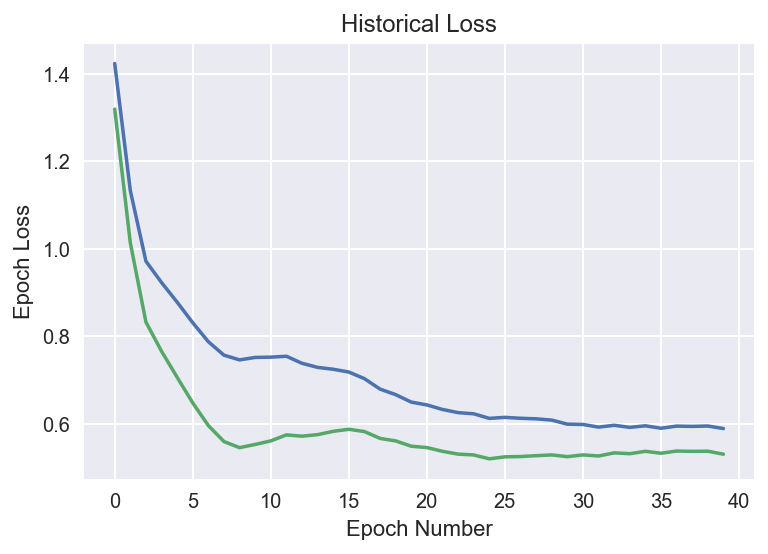

In [76]:
model_drm.fit(X_train, y_train)

In [77]:
pred_train_drm = model_drm.predict(X_train)
pred_test_drm = model_drm.predict(X_test)

In [78]:
cc_train_drm = CostCurve(arr=y_train, scores=pred_train_drm)
cc_test_drm = CostCurve(arr=y_test, scores=pred_test_drm)

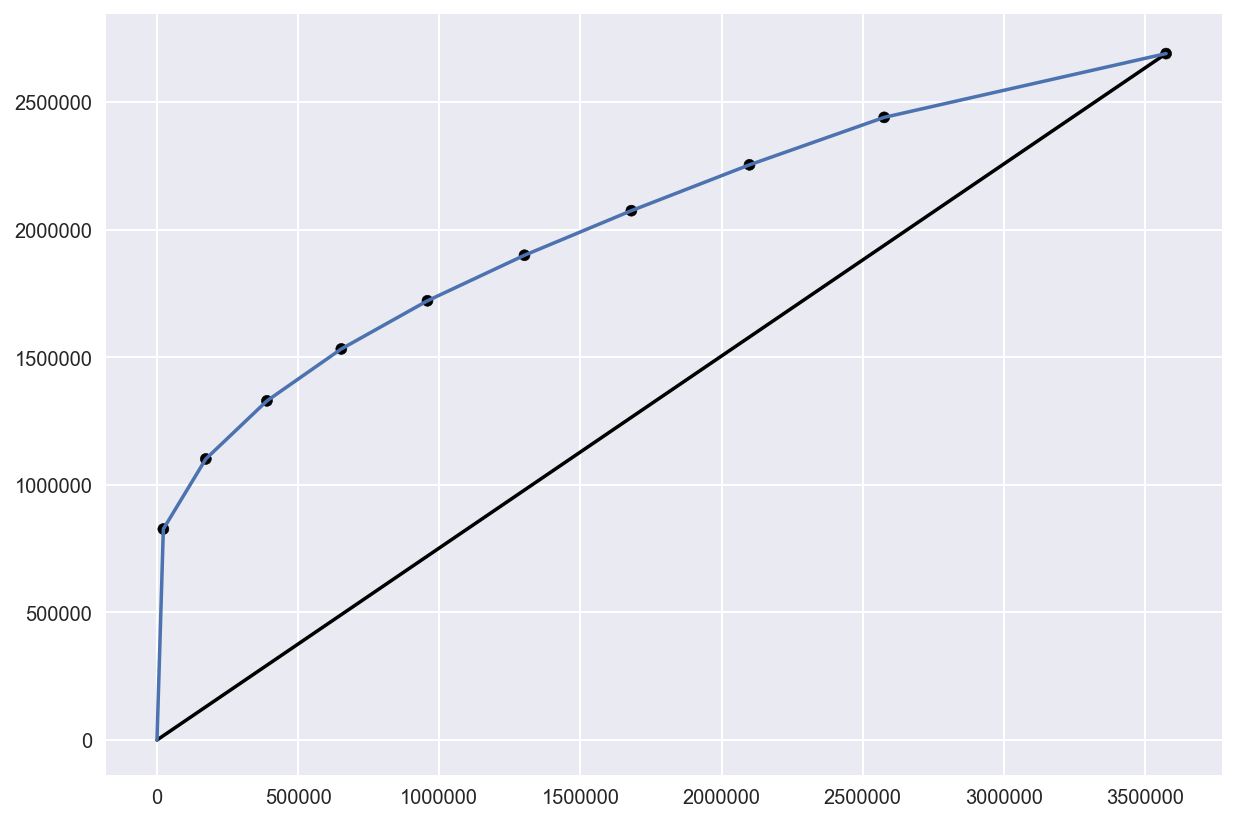

In [79]:
cc_train_drm.plot_curve()

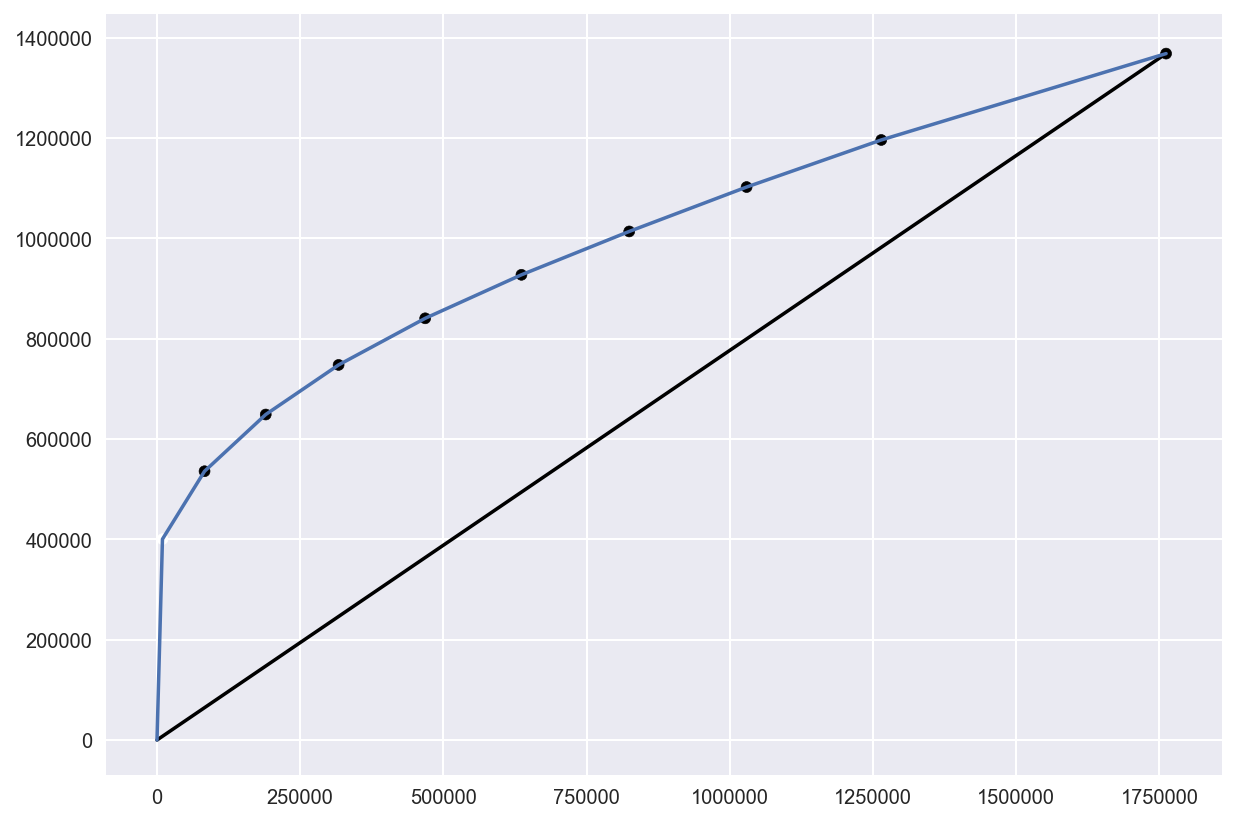

In [80]:
cc_test_drm.plot_curve()

In [81]:
model_rlearner_linear = RLearnerRidge()

In [82]:
model_rlearner_linear.fit(X=X_train, w=y_train[:, -1], y=2*y_train[:,0] - y_train[:,1])

In [83]:
pred_train_r = model_rlearner_linear.predict(X_train)
pred_test_r = model_rlearner_linear.predict(X_test)

In [84]:
cc_train_r = CostCurve(arr=y_train, scores=pred_train_r)
cc_test_r = CostCurve(arr=y_test, scores=pred_test_r)

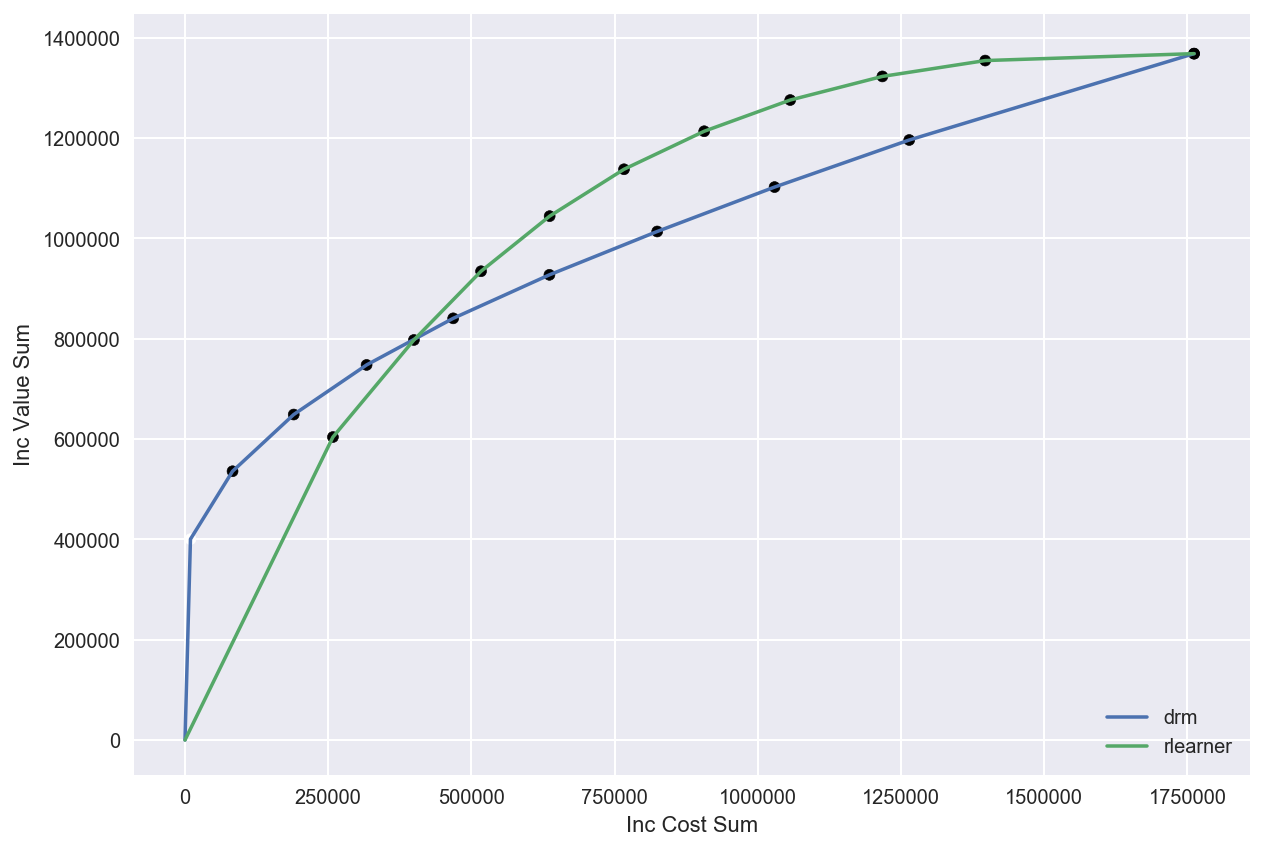

In [85]:
CostCurve.plot_multiple_cost_curves(
    {
        'drm': cc_test_drm,
        'rlearner': cc_test_r,
    }
)